## 4.0_SynAnalyzer_PlotImarisResults_BclwTGAging_2025.ipynb
Created by: JFranco | 25 SEP 2024 | Env: SynAnalyzer | Last run: 13 FEB 2025

This Python notebook allows a user to review the XYZ data as it was originally taken from the Imaris Stats Files. The main plots produced for each data set (i.e., either pre or post synaptic surface reconstructions) are:
(1) Distribution of surface volumes
(2) Distribution of surface intensities for each channel in the original image
(3) Number of surfaces per HC 
*For each of these plots the notebook also allows the user to compare conditions

REQUIRES: 
   
    - All files organized according to SynAnalyzer structure 
    - XYZ csv files produced by the 1.0_SynAnalyzer_ConvertImarisStatsFiles notebooks (either local or through Google Collab)
    - Imaging metadata sheet compiled by 3.0_SynAnalyzer_CompileImagingMD (either v1 or v2) 
    - Sample metadata sheet either manually generated or compiled by 3.1_SynAnalyzer_CompileSampleMetadata
    - User specifications:
        - Preps to include in the analysis
        - Frequency regions to analyze
        - Whether to plot pre-, post-, or both data sets

In [3]:
#     *** IMPORT PACKAGES **
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns
from statistics import median
import math

In [4]:
#                   *** GET TIME OF ANALYSIS START ***
# could turn this into a module?
toa = str(datetime.datetime.today()).split()                                   #Time of analysis
today = toa[0]
now = toa[1]
timestamp = today.replace('-','')+'-'+now.replace(':','')[:6]

### SETUP PARAMETERS FOR THIS ANALYSIS 

In [5]:
#     *** WHAT TO ANALYZE // WHERE TO GET/STORE **
# Batch analysis directory (where the new metadata sheet will be stored)
batchID = 'SynAnalyzer_BclwTGAging'      
# Preps that are included in the analysis
preps = ['WSS_048','WSS_049']
# Frequencies to include in analysis
freqs = [32, 45]
# Surfaces to include in the analysis
#surfs = ['PreSyn','PostSyn']
surfs = ['PreSyn']
# Metadata fields to grab & use as plotting parameters
mdSFields = ['AnimalID','Sex','DOB','Group']
mdIFields = ['Freq','NoHCRecon']
# Define condition (used for plotting) - Variables declared above and pasted here for reference
condToTest = ['Group']
#condOneVals = ['Uninjected','mTagBFP','HABclw']
#condTwoVals = ['Sham','Exposed']
conditions = ['Cre-;Young','Cre+;Young','Cre-;Old','Cre+;Old',]
# Parameters for plotting
pltOrder = conditions
colors = {pltOrder[0]:'goldenrod' , pltOrder[1]:'gold', pltOrder[2]:'darkslateblue', pltOrder[3]:'slateblue' }
ecdfColors = ['goldenrod','gold', 'darkslateblue', 'slateblue']

# Directories 
#   existing ones 
dirMain = '/Users/joyfranco/Dropbox (Partners HealthCare)/JF_Shared/Data/WSS/'
dirBA = dirMain+'BatchAnalysis/'+batchID+'/'
dirMD = dirBA+'Metadata/'
dirXYZs = dirBA+'XYZCSVs/'
dirSA = dirBA+'SAR.Analysis/'

#   ones that need to be made    
dirRes = dirBA+'SAR.Results/'
dirTR = dirRes+timestamp+'/'


# Files to access
fnMDSamp = batchID+'.Metadata.Samples.csv'
fnMDIms = batchID+'.Metadata.Imaging.csv'
fnBM = 'SynAnalyzerBatchMaster.csv'

### INITIALIZE DIRECTORY AND FILES FOR ANALYSIS

In [6]:
#    *** INITIALIZE RUN SPECIFIC DIRECTORY ETC FOR STORING RESULTS **
# Create directory for storing spreadsheets and summary plots for this run
if not os.path.exists(dirRes): os.mkdir(dirRes)
if not os.path.exists(dirTR): os.mkdir(dirTR)

In [7]:
#    *** LOAD MD SHEETS **
# Sample metadata sheet that include animal and condition info
dfSamps = pd.read_csv(dirMD+fnMDSamp)
dfSamps.reset_index(inplace=True)
# Imaging metadata sheet that includes frequency and NoHC info
dfIms = pd.read_csv(dirMD+fnMDIms)
dfIms.drop('Unnamed: 0', axis=1, inplace=True)
#dfIms.reset_index(inplace=True)
dfBM = pd.read_csv(dirSA+fnBM)
dfBM.reset_index(inplace=True)

In [8]:
# Create a df that has every XYZ surface created in Imaris for the images in the MD sheet
#   that meet the user specifications

# Subset the imaging metadataframe to only include the images that are the right frequency
#    This df will be used as a "master" sheet for tracking summary values per image
dfImsSS = dfIms[dfIms['Freq'].isin(freqs)].copy()
dfImsSS.reset_index(inplace=True)
dfImsSS.drop('index', axis=1, inplace=True)

###   COMPILE DATA FROM ALL IMAGES INCLUDED IN ANALYSIS

In [14]:
#  *** COMPILE BATCH MASTER DATA ***
# Add metadata for each image to the batch master and calculate image stats
imList = dfIms['ImageName']
for im in imList:

    # Get the index of the image in Ims MD df
    inIm = dfIms.index[dfIms['ImageName']==im].tolist()[0]
    
    # Check that the image has reconstructed hair cells
    noHCRecon = dfIms.loc[inIm]['NoHCRecon']
    if not (math.isnan(noHCRecon)):
        # Get the index of the image in Batch Master
        inBM = dfBM.index[dfBM['ImageName']==(im+'.czi')].tolist()[0]
        # For images that have valid hair cell reconstructed information --->
        # Get other key information from imaging MD sheet
        samp = dfIms.loc[inIm]['SlideID']
        freq = dfIms.loc[inIm]['Freq']
        # Get information from sample MD sheet
        inSamp = dfSamps.index[dfSamps['SampleID']==samp].tolist()[0]
        anID = dfSamps.loc[inSamp]['AnimalID']
        group = dfSamps.loc[inSamp]['Group']
        # Get information on the number of synapses
        pSyn = int(dfBM.loc[inBM]['PreSyn_nPillar'])
        mSyn = int(dfBM.loc[inBM]['PreSyn_nModiolar'])
        nSyn = int(dfBM.loc[inBM]['PreSyn_nSynapses'])
        nSurf = int(dfBM.loc[inBM]['PreSynXYZ'])
        
        # Add all relevant information to this entry of the Batch Master
        dfBM.at[inBM, 'AnimalID'] = anID
        dfBM.at[inBM, 'Group'] = group
        dfBM.at[inBM, 'Freq'] = freq
        dfBM.at[inBM, 'NoHC'] = noHCRecon
        
        dfBM.at[inBM,'ModProp']= mSyn/(pSyn+mSyn)
        dfBM.at[inBM,'SynPerHC']= nSyn/noHCRecon
        dfBM.at[inBM,'SurfPerHC']= nSurf/noHCRecon
        

In [11]:
#  *** COMPILE XYZ DATA ***
# Initialize a data frame for storing information for every sample 
dfISS = pd.DataFrame()
# Initialize a data frame for storying all XYZ data
dfXYZAll = pd.DataFrame()
# Iterate through the available XYZ sheets from SynAnalyzer to compile the results
imList = dfImsSS['ImageName']
for im in imList:
    # Get the index of the image in Ims MD df
    inIm = dfImsSS.index[dfImsSS['ImageName']==im].tolist()[0]
    # Check that the image has reconstructed hair cells
    noHCRecon = dfImsSS.loc[inIm]['NoHCRecon']
    if not (math.isnan(noHCRecon)):
        # For images that have valid hair cell reconstructed information --->
        # Get other key information from imaging MD sheet
        samp = dfImsSS.loc[inIm]['SlideID']
        freq = dfImsSS.loc[inIm]['Freq']
        noHC = dfImsSS.loc[inIm]['NoHCRecon']
        # Geet information from sample MD sheet
        inSamp = dfSamps.index[dfSamps['SampleID']==samp].tolist()[0]
        anID = dfSamps.loc[inSamp]['AnimalID']
        group = dfSamps.loc[inSamp]['Group']
        #sex = dfSamps.loc[inSamp]['Sex']
        #dob = dfSamps.loc[inSamp]['DOB']
        #geno = dfSamps.loc[inSamp]['Genotype']
        #treat = dfSamps.loc[inSamp]['Treatment']
        #neStatus = dfSamps.loc[inSamp]['NoiseExposed']
        
        """
        # Define condition (used for plotting) - Variables declared above and pasted here for reference
        #condToTest = ['Treament','NoiseExposed']
        #condOneVals = ['Uninjected','mTagBFP','HABclw']
        #condTwoVals = ['Sham','Exposed']
        #conditions = ['UnInj\nSham','UnInj\nExposed','CtrlInj\nSham','CtrlInj\nExposed','BclwInj\nSham','BclwInj\nExposed']
        if ((dfIms.loc[inIm][condToTest[0]] == condOneVals[0]) & (dfIms.loc[inIm][condToTest[1]] == condTwoVals[0])):
            # Condition = Uninjected Sham 
            cond = conditions[0]
        elif ((dfIms.loc[inIm][condToTest[0]] == condOneVals[0]) & (dfIms.loc[inIm][condToTest[1]] == condTwoVals[1])):
            # Condition = Uninjected Exposed 
            cond = conditions[1]
        elif ((dfIms.loc[inIm][condToTest[0]] == condOneVals[1]) & (dfIms.loc[inIm][condToTest[1]] == condTwoVals[0])):
            # Condition = CTRL Injected Sham 
            cond = conditions[2]
        elif ((dfIms.loc[inIm][condToTest[0]] == condOneVals[1]) & (dfIms.loc[inIm][condToTest[1]] == condTwoVals[1])):
            # Condition = CTRL Injected Exposed 
            cond = conditions[3]
        elif ((dfIms.loc[inIm][condToTest[0]] == condOneVals[2]) & (dfIms.loc[inIm][condToTest[1]] == condTwoVals[0])):
            # Condition = HABclw Injected Sham
            cond = conditions[4]
        elif ((dfIms.loc[inIm][condToTest[0]] == condOneVals[2]) & (dfIms.loc[inIm][condToTest[1]] == condTwoVals[1])):
            # Condition = HABclw Injected Exposed 
            cond = conditions[5]
        dfIms.at[inIm, 'Condition']=cond
        """
        # Setup the df for this image to add to add to dfISS
        df = pd.DataFrame({'ImageName': im, 
                           'SampleID':samp, 
                           'Freq':[freq],
                           'NoHCRecon':[noHC],
                           'AnimalID':anID,
                           #'Sex':sex,
                           #'DOB':dob,
                           #'Genotype':geno,
                           #'Treatment':treat,
                           #'NoiseExposed':neStatus,
                           #'Condition':cond})
                           'Group':group})
        
        # Iterate through the surface types to include
        # Iterate through surfs for this image to capture 
        i = 0
        for surf in surfs:
            # Setup the filename to open
            fnXYZ = im+'.XYZ.'+surf+'.csv'
            if os.path.exists(dirSA+fnXYZ):
                # Load the XYZ data
                dfXYZ = pd.read_csv(dirSA+fnXYZ)
                # Add important md to each row
                dfXYZ['ImageName']=im
                dfXYZ['SampleID']=samp
                #dfXYZ['Genotype']=geno
                #dfXYZ['NoiseExposed']=neStatus
                dfXYZ['Freq']=freq
                dfXYZ['Surf']=surf
                #dfXYZ['Condition']=cond
                dfXYZ['Group']=group
                
                # Count the number of surfaces and categories
                nAll = len(dfXYZ)
                nSyns = len(dfXYZ[dfXYZ['SynapseStatus']==('Synapse' or 'Doublet')])
                nOrph = len(dfXYZ[dfXYZ['SynapseStatus']==('Orphan')])
                nMod = len(dfXYZ[(dfXYZ['PillarModiolarStatus']==('Modiolar')) & (dfXYZ['SynapseStatus']==('Synapse' or 'Doublet'))])
                nPill = len(dfXYZ[(dfXYZ['PillarModiolarStatus']==('Pillar')) & (dfXYZ['SynapseStatus']==('Synapse' or 'Doublet'))])
                uVol = dfXYZ['Volume_um3'].mean()
                uCh1 = dfXYZ['uIntCh_1'].mean()
                uCh2 = dfXYZ['uIntCh_2'].mean()
                uCh3 = dfXYZ['uIntCh_3'].mean()
                uCh4 = dfXYZ['uIntCh_4'].mean()
                maxCh3 = dfXYZ['uIntCh_3'].max()
                
                # Add summary data to image df
                df[surf+'_Total']=nAll
                df[surf+'_nSyns']=nSyns
                df[surf+'_nOrph']=nOrph
                df[surf+'_nPill']=nPill
                df[surf+'_nMod']=nMod
                df['Avg_'+surf+'_SynPerHC']=nSyns/noHC
                #df[surf+'_PropPill']=nPill/nSyns
                #df[surf+'_PropMod']=nMod/nSyns
                df[surf+'_uVol_um3']= uVol
                df[surf+'_uIntCh1']= uCh1
                df[surf+'_uIntCh2']= uCh2
                df[surf+'_uIntCh3']= uCh3
                df[surf+'_uIntCh4']= uCh4
                df[surf+'_maxIntCh3']= maxCh3
    
                # Calculate the mean normalized vals for each surface
                dfXYZ['uNormVol'] = dfXYZ['Volume_um3']/uVol
                dfXYZ['uNormIntCh1'] = dfXYZ['uIntCh_1']/uCh1
                dfXYZ['uNormIntCh2'] = dfXYZ['uIntCh_2']/uCh2
                dfXYZ['uNormIntCh3'] = dfXYZ['uIntCh_3']/uCh3
                dfXYZ['uNormIntCh4'] = dfXYZ['uIntCh_4']/uCh4
                dfXYZ['maxNormIntCh3'] = dfXYZ['uIntCh_3']/maxCh3
    
                # Add it to the main df
                dfXYZAll = pd.concat([dfXYZAll,dfXYZ])

                # Add information to the image summary sheet df
                dfISS = pd.concat([dfISS,df])

# Save the updated sheets
dfXYZAll.to_csv(dirTR+batchID+'.XYZSummary.csv') 
dfISS.to_csv(dirTR+batchID+'.ImageSummary.csv') 

### GENERATE PLOTS

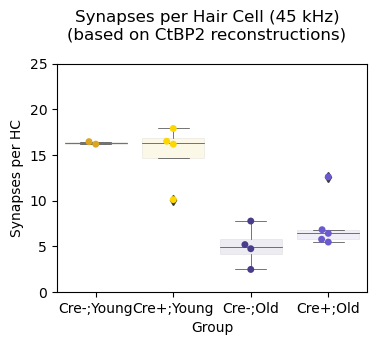

In [30]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSyn_AvgSynPerHC'
plottype = 'BoxSwarm'
region = 45
title = 'Synapses per Hair Cell ('+str(region)+' kHz)\n(based on CtBP2 reconstructions)'
hue = 'Group'
x = 'Group'
y = 'Avg_PreSyn_SynPerHC'
ymin = 0
ymax = 25
xlab = 'Group'
ylab = 'Synapses per HC'

# *** MAKE PLOT ***
fig= plt.figure(figsize=(4,3))
plt.subplots_adjust(top = 0.8, bottom=0.04, hspace=.3, wspace=.2)
fig.suptitle(title)
ax1 = sns.swarmplot(data=dfISS[(dfISS['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfISS[(dfISS['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax1, dodge = False,linewidth=.5)
ax1.set_ylim((ymin, ymax))
ax1.set(xlabel=xlab)
ax1.set(ylabel=ylab)
ax1.get_legend().remove()

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

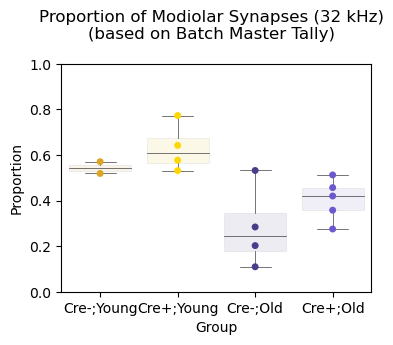

In [28]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'BM_SynPerHC'
plottype = 'BoxSwarm'
region = 32
title = 'Proportion of Modiolar Synapses ('+str(region)+' kHz)\n(based on Batch Master Tally)'
hue = 'Group'
x = 'Group'
y = 'ModProp'
ymin = 0
ymax = 1
xlab = 'Group'
ylab = 'Proportion'

# *** MAKE PLOT ***
fig= plt.figure(figsize=(4,3))
plt.subplots_adjust(top = 0.8, bottom=0.04, hspace=.3, wspace=.2)
fig.suptitle(title)
ax1 = sns.swarmplot(data=dfBM[(dfBM['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfBM[(dfBM['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax1, dodge = False,linewidth=.5)
ax1.set_ylim((ymin, ymax))
ax1.set(xlabel=xlab)
ax1.set(ylabel=ylab)
ax1.get_legend().remove()

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

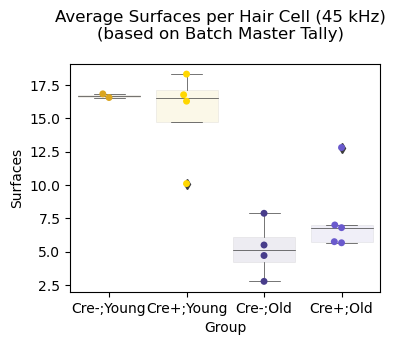

In [33]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'BM_SurfPerHC'
plottype = 'BoxSwarm'
region = 45
title = 'Average Surfaces per Hair Cell ('+str(region)+' kHz)\n(based on Batch Master Tally)'
hue = 'Group'
x = 'Group'
y = 'SurfPerHC'
ymin = 0
ymax = 1
xlab = 'Group'
ylab = 'Surfaces'

# *** MAKE PLOT ***
fig= plt.figure(figsize=(4,3))
plt.subplots_adjust(top = 0.8, bottom=0.04, hspace=.3, wspace=.2)
fig.suptitle(title)
ax1 = sns.swarmplot(data=dfBM[(dfBM['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfBM[(dfBM['Freq']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax1, dodge = False,linewidth=.5)
#ax1.set_ylim((ymin, ymax))
ax1.set(xlabel=xlab)
ax1.set(ylabel=ylab)
ax1.get_legend().remove()

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')